In [1]:
import numpy as np # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
import matplotlib_inline # to edit the inline plot format
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg') # to make plots in pdf (vector) format
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import uproot # for reading .root files
import awkward as ak # to represent nested data in columnar format
import vector # for 4-momentum calculations
import time

In [2]:
MeV = 0.001
GeV = 1.0

In [3]:
samples = {
    'Data' : {
        'list' : ['data15.EOD_0L.root',
                  'data16.EOD_0L.root'],
    },
    'Signal' : { 
        'list' : ['345056.PowhegPythia8EvtGen_NNPDF3_AZNLO_ZH125J_MINLO_vvbb_VpT.EOD_0L.root', 
                '345058.PowhegPythia8EvtGen_NNPDF3_AZNLO_ggZH125_vvbb.EOD_0L.root'],
        'color' : ""
    },
    r'Background $t\\bar{t}$' : { 
        'list' : ['410470.PhPy8EG_A14_ttbar_hdamp258p75_nonallhad.EOD_0L.root'],
        'color' : ""
    },
    'Background Single top' : { 
        'list' : ['410644.PowhegPythia8EvtGen_A14_singletop_schan_lept_top.EOD_0L.root',
                '410645.PowhegPythia8EvtGen_A14_singletop_schan_lept_antitop.EOD_0L.root',
                '410658.PhPy8EG_A14_tchan_BW50_lept_top.EOD_0L.root',
                '410659.PhPy8EG_A14_tchan_BW50_lept_antitop.EOD_0L.root'],
        'color' : ""
    },
    r'Background $V+$jets' : { 
        'list' : ['700335.Sh_2211_Znunu_pTV2_BFilter.EOD_0L.root',
                '700336.Sh_2211_Znunu_pTV2_CFilterBVeto.EOD_0L.root',
                '700337.Sh_2211_Znunu_pTV2_CVetoBVeto.EOD_0L.root',
                '700358.Sh_2211_Zee2jets_Min_N_TChannel.EOD_0L.root',
                '700359.Sh_2211_Zmm2jets_Min_N_TChannel.EOD_0L.root',
                '700360.Sh_2211_Ztt2jets_Min_N_TChannel.EOD_0L.root',
                '700361.Sh_2211_Znunu2jets_Min_N_TChannel.EOD_0L.root',
                '700467.Sh_2211_Zee_maxHTpTV2_m10_40_pT5_BFilter.EOD_0L.root',
                '700468.Sh_2211_Zee_maxHTpTV2_m10_40_pT5_CFilterBVeto.EOD_0L.root',
                '700469.Sh_2211_Zee_maxHTpTV2_m10_40_pT5_CVetoBVeto.EOD_0L.root',
                '700470.Sh_2211_Zmumu_maxHTpTV2_m10_40_pT5_BFilter.EOD_0L.root',
                '700471.Sh_2211_Zmumu_maxHTpTV2_m10_40_pT5_CFilterBVeto.EOD_0L.root',
                '700472.Sh_2211_Zmumu_maxHTpTV2_m10_40_pT5_CVetoBVeto.EOD_0L.root',
                '700792.Sh_2214_Ztautau_maxHTpTV2_BFilter.EOD_0L.root',
                '700793.Sh_2214_Ztautau_maxHTpTV2_CFilterBVeto.EOD_0L.root',
                '700794.Sh_2214_Ztautau_maxHTpTV2_CVetoBVeto.EOD_0L.root',
                '700843.Sh_2214_Wqq_ptW_200_ECMS.EOD_0L.root',
                '700849.Sh_2214_Zqq_ptZ_200_ECMS.EOD_0L.root',
                '700901.Sh_2214_Ztt_maxHTpTV2_Mll10_40_BFilter.EOD_0L.root',
                '700902.Sh_2214_Ztt_maxHTpTV2_Mll10_40_CFilterBVeto.EOD_0L.root',
                '700903.Sh_2214_Ztt_maxHTpTV2_Mll10_40_CVetoBVeto.EOD_0L.root'],
        'color' : ""
    },
    'Background Diboson' : { 
        'list' : ['700488.Sh_2211_WlvWqq.EOD_0L.root',
                '700489.Sh_2211_WlvZqq.EOD_0L.root',
                '700490.Sh_2211_WlvZbb.EOD_0L.root',
                '700491.Sh_2211_WqqZvv.EOD_0L.root',
                '700492.Sh_2211_WqqZll.EOD_0L.root',
                '700493.Sh_2211_ZqqZll.EOD_0L.root',
                '700494.Sh_2211_ZbbZll.EOD_0L.root',
                '700495.Sh_2211_ZqqZvv.EOD_0L.root',
                '700496.Sh_2211_ZbbZvv.EOD_0L.root',
                '700195.Sh_2210_eegammagamma.EOD_0L.root',
                '700196.Sh_2210_mumugammagamma.EOD_0L.root',
                '700199.Sh_2210_enugammagamma.EOD_0L.root',
                '700200.Sh_2210_munugammagamma.EOD_0L.root',
                '700201.Sh_2210_taunugammagamma.EOD_0L.root'],
        'color' : ""
    }
}

In [4]:
# CERN open database URL
path = "https://atlas-opendata.web.cern.ch/atlas-opendata/13TeV/bb0L/"

# Data

In [5]:
data15_path = path + "Data/" + "data15.EOD_0L.root"    
data16_path = path + "Data/" + "data16.EOD_0L.root"    

In [6]:
with uproot.open(data16_path + ":analysis") as t:
    tree = t
tree.num_entries

0

In [28]:
tree['trigMET'].arrays()

<Array [{trigMET: True}, {...}, ..., {...}] type='1868591 * {trigMET: bool}'>

In [26]:
# Accessing the file from the online database (":analysis" opens the tree in a desired manner)
with uproot.open(data15_path + ":analysis") as t:
    tree = t

mask0 = ak.num(tree['jet_pt'].arrays()['jet_pt'])>0
mask1 = ak.num(tree['jet_pt'].arrays()['jet_pt'])>1

jet_pt_plot = tree['jet_pt'].arrays()[mask0]
leading_jet_pt = jet_pt_plot[:,0]['jet_pt']
jet_pt_plot = tree['jet_pt'].arrays()[mask1]
subleading_jet_pt = jet_pt_plot[:,1]['jet_pt']

missing_et = tree['met'].arrays()['met']

jet_eta_plot = tree['jet_eta'].arrays()[mask0]
leading_jet_eta = jet_eta_plot[:,0]['jet_eta']
jet_eta_plot = tree['jet_eta'].arrays()[mask1]
subleading_jet_eta = jet_eta_plot[:,1]['jet_eta']

Text(0.5, 1.0, 'leading jet pt')

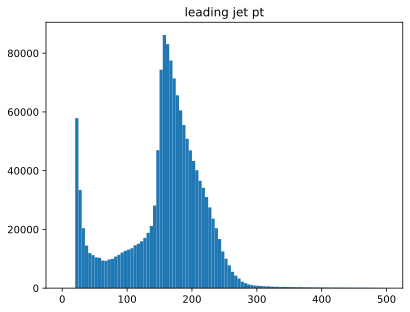

In [9]:
xmin = 0 
xmax = 500 
step_size = 5 * GeV
bin_edges = np.arange(start=xmin, stop=xmax+step_size, step=step_size ) 

plt.hist(leading_jet_pt, bins=bin_edges)
plt.title("leading jet pt")

Text(0.5, 1.0, 'subleading jet pt')

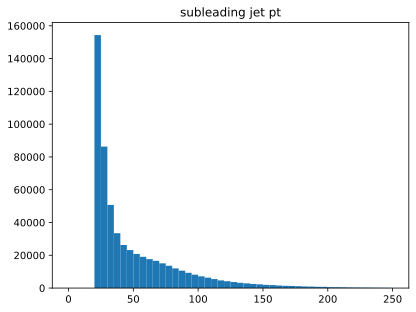

In [10]:
xmin = 0 
xmax = 250 
step_size = 5 * GeV
bin_edges = np.arange(start=xmin, stop=xmax+step_size, step=step_size ) 

plt.hist(subleading_jet_pt, bins=bin_edges)
plt.title("subleading jet pt")

Text(0.5, 1.0, 'leading jet $\\eta$')

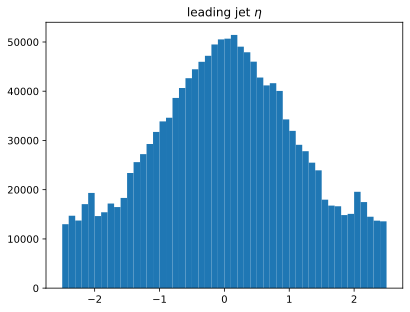

In [11]:
xmin = -2.5
xmax = 2.5
step_size = 0.1
bin_edges = np.arange(start=xmin, stop=xmax+step_size, step=step_size ) 

plt.hist(leading_jet_eta, bins=bin_edges)
plt.title(r"leading jet $\eta$")

Text(0.5, 1.0, 'subleading jet $\\eta$')

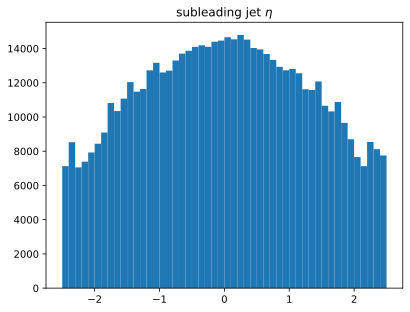

In [12]:
xmin = -2.5
xmax = 2.5
step_size = 0.1
bin_edges = np.arange(start=xmin, stop=xmax+step_size, step=step_size ) 

plt.hist(subleading_jet_eta, bins=bin_edges)
plt.title(r"subleading jet $\eta$")

Text(0.5, 1.0, 'missing E_t')

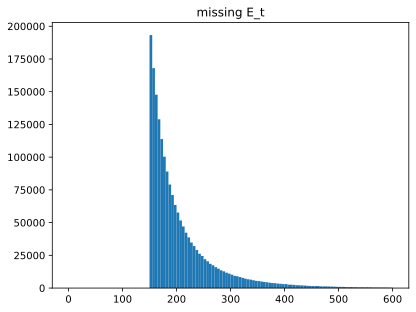

In [13]:
xmin = 0 
xmax = 600
step_size = 5 * GeV
bin_edges = np.arange(start=xmin, stop=xmax+step_size, step=step_size ) 

met_hist_data = plt.hist(missing_et, bins=bin_edges)
plt.title("missing E_t")

# MC

In [14]:
background_path = path + "MC/" + samples['Background Diboson']['list'][-1]
# background_path = path + "MC/" + samples['Background $V+$jets']['list'][0]

In [15]:
background_path 

'https://atlas-opendata.web.cern.ch/atlas-opendata/13TeV/bb0L/MC/700201.Sh_2210_taunugammagamma.EOD_0L.root'

In [16]:
with uproot.open(background_path + ":analysis") as t:
    tree = t
tree['kfac'].arrays()[0], tree['filteff'].arrays()[0], tree['xsec'].arrays()[0]

(<Record {kfac: 1} type='{kfac: float32}'>,
 <Record {filteff: 1} type='{filteff: float32}'>,
 <Record {xsec: 2.01} type='{xsec: float32}'>)

In [17]:
weight_variables = ['xsec', 'mcWeight', 'ScaleFactor_PILEUP', 'ScaleFactor_BTAG', 'filteff', 'kfac'] #, 'sum_weights']
lumi = 3.2

def calc_weight(weight_variables, events):
    total_weight = lumi * 1000 / events["sumWeights"]
    for variable in weight_variables:
        total_weight = total_weight * events[variable]
    return total_weight

In [18]:
# Accessing the file from the online database (":analysis" opens the tree in a desired manner)
with uproot.open(background_path + ":analysis") as t:
    tree = t

jet_pt = tree['jet_pt'].arrays()[ak.num(tree['jet_pt'].arrays()['jet_pt'])>0]
leading_jet_pt = jet_pt[:,0]['jet_pt']
jet_pt = tree['jet_pt'].arrays()[ak.num(tree['jet_pt'].arrays()['jet_pt'])>1]
subleading_jet_pt = jet_pt[:,1]['jet_pt']

jet_eta = tree['jet_eta'].arrays()[ak.num(tree['jet_eta'].arrays()['jet_eta'])>0]
leading_jet_eta = jet_eta[:,0]['jet_eta']
jet_eta = tree['jet_eta'].arrays()[ak.num(tree['jet_eta'].arrays()['jet_eta'])>1]
subleading_jet_eta = jet_eta[:,1]['jet_eta']

missing_et = tree['met'].arrays()['met']

missing_et_weights = calc_weight(weight_variables, tree.arrays())
leading_jet_weights = calc_weight(weight_variables, tree.arrays())[ak.num(tree['jet_eta'].arrays()['jet_eta'])>0]
subleading_jet_weights = calc_weight(weight_variables, tree.arrays())[ak.num(tree['jet_eta'].arrays()['jet_eta'])>1]

Text(0.5, 1.0, 'V+jets leading jet pt')

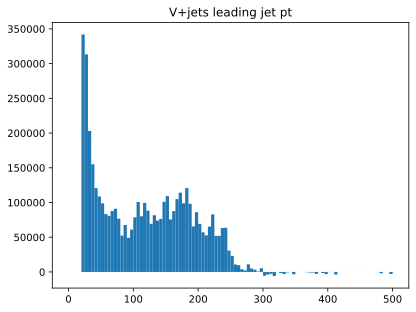

In [19]:
xmin = 0 
xmax = 500 
step_size = 5 * GeV
bin_edges = np.arange(start=xmin, stop=xmax+step_size, step=step_size ) 

plt.hist(leading_jet_pt, weights=leading_jet_weights, bins=bin_edges)
plt.title("V+jets leading jet pt")

Text(0.5, 1.0, 'V+jets subleading jet pt')

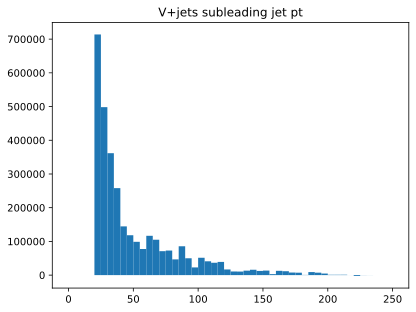

In [20]:
xmin = 0 
xmax = 250 
step_size = 5 * GeV
bin_edges = np.arange(start=xmin, stop=xmax+step_size, step=step_size ) 

plt.hist(subleading_jet_pt, weights=subleading_jet_weights, bins=bin_edges)
plt.title("V+jets subleading jet pt")

Text(0.5, 1.0, 'V+jets leading jet $\\eta$')

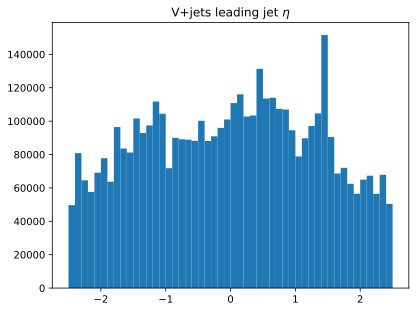

In [21]:
xmin = -2.5
xmax = 2.5
step_size = 0.1
bin_edges = np.arange(start=xmin, stop=xmax+step_size, step=step_size ) 

plt.hist(leading_jet_eta, weights=leading_jet_weights, bins=bin_edges)
plt.title(r"V+jets leading jet $\eta$")

Text(0.5, 1.0, 'V+jets subleading jet $\\eta$')

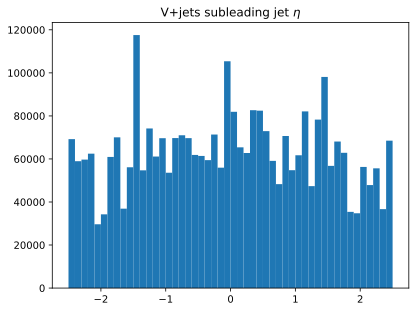

In [22]:
xmin = -2.5
xmax = 2.5
step_size = 0.1
bin_edges = np.arange(start=xmin, stop=xmax+step_size, step=step_size ) 

plt.hist(subleading_jet_eta, weights=subleading_jet_weights, bins=bin_edges)
plt.title(r"V+jets subleading jet $\eta$")

Text(0.5, 1.0, 'V+jets missing E_t')

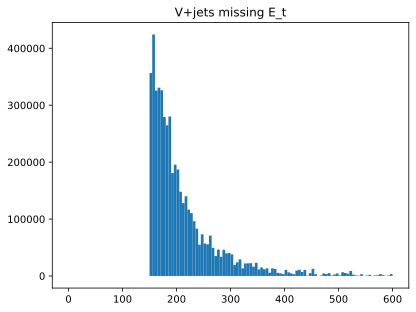

In [23]:
xmin = 0 
xmax = 600
step_size = 5 * GeV
bin_edges = np.arange(start=xmin, stop=xmax+step_size, step=step_size ) 

met_hist_bg = plt.hist(missing_et, weights=missing_et_weights, bins=bin_edges)
plt.title("V+jets missing E_t")

Check that the samples are all spelled right

In [24]:
met_hist_data[0].sum(), met_hist_bg[0].sum()

(np.float64(1860637.0), np.float64(5055198.5))

In [25]:
# for key in samples:
#     if key != 'Data':
#         for item in samples[key]['list']:
#             background = path + "MC/" + item
#         with uproot.open(background + ":analysis") as t:
#             tree = t